<a href="https://colab.research.google.com/github/caua-sathler/NEURAL-NETWORKS/blob/main/FL-PSO-SGD/FLPSO_SGD_Clients_unbalanced_extreme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FLPSO-ADAM : desbalanceamento mais extremo:

1) Primeiro, distribui 500 amostras de cada dígito para cada cliente.

2) Depois, com as 35000 amostras de treino restantes, distribuí da seguinte forma:

    - TODOS os dígitos 0 e 1 dessas 35000 foram para o cliente 0.

    - TODOS os dígitos 2 e 3 dessas 35000 foram para o cliente 1 e assim por diante.

Dessa forma, todos os clientes tem acesso um pouco de cada amostra, mas tem uma quantidade muito maior de amostras de dois dígitos específicos

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F
import copy
import random
import torchvision
import torchvision.models as models
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
import numpy as np
from collections import OrderedDict

In [ ]:
class MLP(nn.Module):

    def __init__(self, device, input_size=28*28, hidden_size=256, num_classes=10):
        super(MLP, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.to(device)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Achatar o tensor de entrada
        y = self.fc1(x)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.relu(y)
        y = self.fc3(y)

        return y

In [ ]:
# Definições dos hiperparâmetros
NUM_CLIENTES = 5
NUM_PARTICULAS = 25
NUM_RODADAS = 50
NUM_DIGITOS = 10
INERCIA, C1, C2 = 0.8, 1.5,  1.9
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'training on {DEVICE}')

# Criando o modelo global
modelo_global = MLP(DEVICE)
criterio = nn.CrossEntropyLoss()

training on cpu


In [ ]:
#Seeds para reprodutibilidade
random.seed(98)
torch.manual_seed(98)
torch.cuda.manual_seed(98)

class Particula:
    def __init__(self, particle_id, modelo_cliente):
        self.particle_id = particle_id
        self.device = modelo_cliente.device
        self.pesos = copy.deepcopy(modelo_cliente.state_dict())

        # Adiciona ruído leve nos pesos para quebrar simetria inicial
        for name in self.pesos:
            self.pesos[name] += 0.01 * torch.randn_like(self.pesos[name])

        self.melhor_pesos = copy.deepcopy(self.pesos)
        self.melhor_erro = float('inf')
        self.velocidade = {name: torch.zeros_like(param) for name, param in self.pesos.items()}

    def atualizar_pso(self, global_best_pesos, INERCIA, C1, C2):
        MAX_VELOCITY = 0.1  # Limite para evitar oscilações grandes
        for name in self.pesos:
            local_rand = random.random()
            global_rand = random.random()
            self.velocidade[name] = (
                INERCIA * self.velocidade[name]
                + C1 * local_rand * (self.melhor_pesos[name] - self.pesos[name])
                + C2 * global_rand * (global_best_pesos[name] - self.pesos[name])
            )

            # Clipping da velocidade
            self.velocidade[name] = torch.clamp(self.velocidade[name], -MAX_VELOCITY, MAX_VELOCITY)

            # Atualiza os pesos com a nova velocidade
            self.pesos[name] += self.velocidade[name]

    def avaliar_perda(self, modelo_cliente, criterio, dados):
        modelo_cliente.load_state_dict(self.pesos)
        modelo_cliente.eval()
        total_loss = 0

        with torch.no_grad():
            for inputs, labels in dados:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = modelo_cliente(inputs)
                loss = criterio(outputs, labels)
                total_loss += loss.item()

        return total_loss / len(dados)


class Cliente:
    def __init__(self, cliente_id, modelo_global, dados, test, num_particulas):
        self.cliente_id = cliente_id
        self.modelo = copy.deepcopy(modelo_global)  # Cada cliente tem seu próprio modelo
        self.dados = dados
        self.test = test
        self.num_particulas = num_particulas
        self.particulas = []
        self.melhor_particula = None
        self.inicializar_particulas(num_particulas)

    def inicializar_particulas(self, num_particulas):
        """Cria um conjunto de partículas associadas ao cliente."""
        self.particulas = [Particula(i, self.modelo) for i in range(num_particulas)]

    def treinar_com_pso(self, INERCIA, C1, C2, global_best_pesos, criterio):
        """Treina as partículas usando PSO e atualiza a melhor partícula local."""

        for particula in self.particulas:

            particula.atualizar_pso(global_best_pesos, INERCIA, C1, C2)
            erro = particula.avaliar_perda(self.modelo, criterio, self.dados)
            if erro < particula.melhor_erro:
                particula.melhor_erro = erro
                particula.melhor_pesos = copy.deepcopy(particula.pesos)

        self.selecionar_melhor_particula()

    def refinar_com_adam(self, criterio):
        """Refina os pesos da melhor partícula usando Adam."""
        self.modelo.load_state_dict(self.melhor_particula.melhor_pesos)
        otimizador = optim.Adam(self.modelo.parameters(), lr=0.007, weight_decay=1e-5)

        self.modelo.train()
        for i in range(1):
          for inputs, labels in self.dados:
              inputs, labels = inputs.to(self.modelo.device), labels.to(self.modelo.device)
              otimizador.zero_grad()
              outputs = self.modelo(inputs)
              loss = criterio(outputs, labels)
              loss.backward()
              otimizador.step()

        # Atualiza os pesos da melhor partícula com os pesos refinados pelo Adam
        self.melhor_particula.melhor_pesos = copy.deepcopy(self.modelo.state_dict())
        self.melhor_particula.melhor_erro = self.calcular_loss(self.modelo, criterio, self.dados)

    def calcular_loss(self, modelo, criterio, dados):
        self.modelo.eval()
        total_loss = 0

        with torch.no_grad():
            for inputs, labels in dados:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = modelo(inputs)
                loss = criterio(outputs, labels)
                total_loss += loss.item()

        return total_loss / len(dados)

    def selecionar_melhor_particula(self):
        """Seleciona a melhor partícula do cliente."""
        self.melhor_particula = min(self.particulas, key=lambda p: p.melhor_erro)


def treinar_federado(modelo_global, clientes, criterio, num_rodadas, INERCIA, C1, C2, testloader):
    """Treina os clientes localmente e sincroniza com o servidor central, validando a acurácia."""

    melhor_peso_global = copy.deepcopy(modelo_global.state_dict())  # Inicializa com o modelo global
    melhor_erro_global = float('inf')
    soma = 0.0;

    for rodada in range(num_rodadas):
        resultados_rodada = []

        for cliente in clientes:
            cliente.treinar_com_pso(INERCIA, C1, C2, melhor_peso_global, criterio)  # Treino com PSO
            cliente.refinar_com_adam(criterio)  # Refinamento com Adam
            erro_cliente = cliente.melhor_particula.melhor_erro  # Obtém o melhor erro do cliente
            pesos_cliente = cliente.melhor_particula.melhor_erro  # Obtém os pesos do modelo do cliente
            resultados_rodada.append((cliente.cliente_id, erro_cliente))

        resultados_sorted = sorted(resultados_rodada, key=lambda x: x[1])
        top_3_results = resultados_sorted[:3]

        melhor_cliente = random.choice(top_3_results)
        melhor_cliente_id = melhor_cliente[0]
        melhor_erro_cliente = melhor_cliente[1]

        melhor_peso_global = copy.deepcopy(clientes[melhor_cliente_id].melhor_particula.melhor_pesos)
        melhor_erro_global = melhor_erro_cliente

        modelo_global.load_state_dict(melhor_peso_global)

        test_loss, test_accuracy = avaliar_modelo(modelo_global, criterio, testloader)
        soma += test_accuracy

        # if (rodada+1) % 10 == 0:
        print(f"Rodada {rodada+1}/{num_rodadas}: Cliente {melhor_cliente_id} enviou os pesos!")
        print(f"Erro Global Atualizado: {melhor_erro_global:.4f}")
        print(f"Teste -> Perda: {test_loss: .4f}, Acurácia: {test_accuracy*100: .2f}%\n")

    print(f"Acurácia média: {soma/num_rodadas: .4f}")
    print("Treinamento Federado Finalizado!")

def avaliar_modelo(modelo, criterio, testloader):
    """Avalia o modelo global no conjunto de teste."""
    modelo.eval()  # Modo de avaliação
    total_loss = 0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = modelo(inputs)
            loss = criterio(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total_samples += labels.size(0)

    test_loss = total_loss / len(testloader)
    test_accuracy = (correct / total_samples)

    return test_loss, test_accuracy

mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True)
X_test = mnist_test.data.view(-1, 28*28).numpy()  # Flatten
y_test = mnist_test.targets.numpy()

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
X_train = mnist_train.data.view(-1, 28*28).numpy()  # Flatten
y_train = mnist_train.targets.numpy()

# Normalização (como foi feito com o Iris)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Converter para tensores
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Criar datasets
trainset = TensorDataset(X_train, y_train)
testset = TensorDataset(X_test, y_test)

def create_unbalanced_subsets(dataset, num_clients, min_per_digit=500):
    targets = dataset.tensors[1].numpy()

    # Índices das classes disponíveis
    class_indices = {digit: np.where(targets == digit)[0] for digit in range(10)}
    for digit in class_indices:
        np.random.shuffle(class_indices[digit])

    # Índices dos clientes
    client_indices = {i: [] for i in range(num_clients)}

    # Distribui inicialmente "min_per_digit" amostras por dígito para cada cliente
    for digit in range(10):
        available_indices = class_indices[digit]

        min_total_samples = num_clients * min_per_digit
        if len(available_indices) < min_total_samples:
            raise ValueError(f"Número insuficiente de amostras para o dígito {digit}")

        for client_id in range(num_clients):
            start_idx = client_id * min_per_digit
            end_idx = start_idx + min_per_digit
            selected = available_indices[start_idx:end_idx]
            client_indices[client_id].extend(selected.tolist())

        class_indices[digit] = available_indices[min_total_samples:]

    # Distribuição exclusiva do restante dos dígitos por cliente
    digits_per_client = [(i*2, i*2+1) for i in range(num_clients)]

    for client_id, (digit_a, digit_b) in enumerate(digits_per_client):
        for digit in [digit_a, digit_b]:
            remaining_indices = class_indices[digit]
            client_indices[client_id].extend(remaining_indices.tolist())
            class_indices[digit] = []  # Zera para garantir que não sejam reutilizados

    # Criar subsets
    subsets = [Subset(dataset, client_indices[i]) for i in range(num_clients)]

    # Mostrar distribuição final
    for client_id in range(num_clients):
        client_targets = targets[client_indices[client_id]]
        digit_counts = {digit: np.sum(client_targets == digit) for digit in range(10)}
        print(f"Cliente {client_id}: {digit_counts}")

    return subsets

train_subsets = create_unbalanced_subsets(trainset, NUM_CLIENTES)

# Criar DataLoaders para cada subset (cliente)
trainloaders = [DataLoader(train_subsets[i], batch_size=240, shuffle=True) for i in range(NUM_CLIENTES)]

testloader = DataLoader(testset, batch_size=240, shuffle=False)

# Criando os clientes
clientes = [Cliente(i, modelo_global, trainloaders[i], testloader, NUM_PARTICULAS) for i in range(NUM_CLIENTES)]

# Executando o treinamento federado
treinar_federado(modelo_global, clientes, criterio, NUM_RODADAS, INERCIA, C1, C2, testloader)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.19MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.74MB/s]


Cliente 0: {0: np.int64(3923), 1: np.int64(4742), 2: np.int64(500), 3: np.int64(500), 4: np.int64(500), 5: np.int64(500), 6: np.int64(500), 7: np.int64(500), 8: np.int64(500), 9: np.int64(500)}
Cliente 1: {0: np.int64(500), 1: np.int64(500), 2: np.int64(3958), 3: np.int64(4131), 4: np.int64(500), 5: np.int64(500), 6: np.int64(500), 7: np.int64(500), 8: np.int64(500), 9: np.int64(500)}
Cliente 2: {0: np.int64(500), 1: np.int64(500), 2: np.int64(500), 3: np.int64(500), 4: np.int64(3842), 5: np.int64(3421), 6: np.int64(500), 7: np.int64(500), 8: np.int64(500), 9: np.int64(500)}
Cliente 3: {0: np.int64(500), 1: np.int64(500), 2: np.int64(500), 3: np.int64(500), 4: np.int64(500), 5: np.int64(500), 6: np.int64(3918), 7: np.int64(4265), 8: np.int64(500), 9: np.int64(500)}
Cliente 4: {0: np.int64(500), 1: np.int64(500), 2: np.int64(500), 3: np.int64(500), 4: np.int64(500), 5: np.int64(500), 6: np.int64(500), 7: np.int64(500), 8: np.int64(3851), 9: np.int64(3949)}
Rodada 1/50: Cliente 2 enviou 

In [ ]:
accuracies = [0.9174, 0.9156, 0.9194, 0.9157, 0.9169, 0.9191, 0.9160, 0.9168, 0.8942, 0.9169]
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print(f"Acurácia média: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")

Acurácia média: 91.48% ± 0.70%


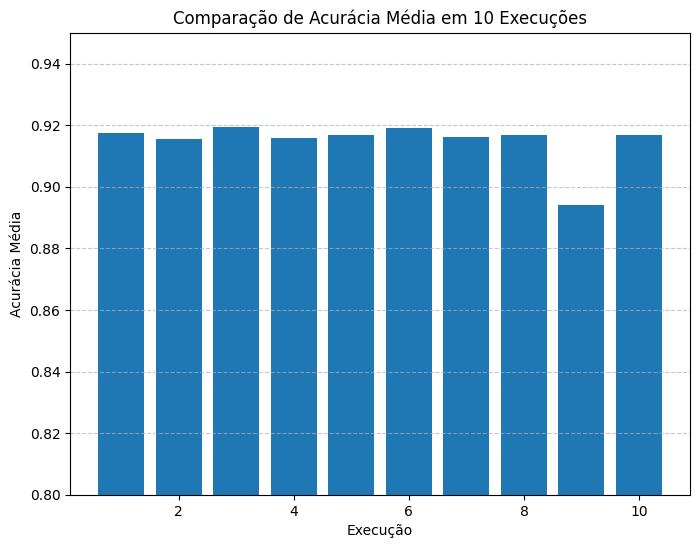

In [ ]:
import matplotlib.pyplot as plt

# Lista de acurácias médias de 10 execuções
acuracias = [0.9174, 0.9156, 0.9194, 0.9157, 0.9169, 0.9191, 0.9160, 0.9168, 0.8942, 0.9169]
execucoes = list(range(1, len(acuracias)+1))

plt.figure(figsize=(8, 6))
plt.bar(execucoes, acuracias)
plt.xlabel("Execução")
plt.ylabel("Acurácia Média")
plt.title("Comparação de Acurácia Média em 10 Execuções")
plt.ylim(0.80, 0.95)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()
